## Modules à importer

In [1]:
import math
import scipy
import numpy as np
import pandas as pd
import iminuit as im
import ipywidgets as ipw
from importlib import reload
from scipy.stats import poisson
from scipy.optimize import fsolve
from variaIa.variaIa import baserate
from scipy.interpolate import interp1d
from variaIa.variaIa import stretchevol
from astropy.cosmology import Planck15 as cosmo
import matplotlib.pyplot as plt
import random

## Définitions et sélection de l'échantillon à utiliser

In [3]:
d = pd.read_csv('../Data/data_cheat.csv', sep=' ', index_col = 'CID')
d_snf = pd.read_csv('../Data/lssfr_paper_full_sntable.csv',sep=',')

surveys = ['SDSS', 'SNLS', 'PS1', 'HST', 'SNF']

su = ipw.Dropdown(options=surveys,
                  description='Survey:',
                  value = 'SDSS')

surv = {'SDSS': d[d['IDSURVEY'] == 1],
        'SNLS': d[d['IDSURVEY'] == 4],
        'PS1':  d[d['IDSURVEY'] == 15],
        'HST':  d[d['IDSURVEY'].isin([101, 100, 106])],
        'SNF':  d_snf}

# .loc[d_snf['name'].str.contains('SNF|LSQ|PTF',na=False,regex=True)]

colors = {'SDSS': 'lime',
          'SNLS': 'red',
          'PS1': 'blue',
          'HST': 'purple',
          'SNF': 'orange'}

zmax = {'SDSS': 0.22,
        'SNLS': 0.70,
        'PS1': 0.33,
        'HST': 10,
        'SNF': 10}

def set_data(su):
    global ns_dataz, dataz, ns_datax, datax
    if su == 'SNF':
        ns_dataz = surv[su]['host.zcmb'].values
        dataz = np.sort(ns_dataz)
        ns_datax = surv[su]['salt2.X1'].values
        datax = np.sort(ns_datax)
    else:
        ns_dataz = surv[su].zCMB.values
        dataz = np.sort(ns_dataz)
        ns_datax = surv[su].x1.values
        datax = np.sort(ns_datax)
    
int_data = ipw.interactive(set_data, su = su)
display(int_data)

interactive(children=(Dropdown(description='Survey:', options=('SDSS', 'SNLS', 'PS1', 'HST', 'SNF'), value='SD…

## Choix des bins pour les listes de redshifts et de stretch

In [4]:
nb_z = ipw.IntSlider(min = 3, max = 30, value = 12, description='#bins for z:', continuous_update=False)

def set_bins_z(nb_z):
    global binsz, bordz, countsz
    bordz = np.asarray(np.histogram(dataz, bins = nb_z)[1])
    binsz = np.asarray([[bordz[i],bordz[i+1]] for i in range(len(bordz)-1)]).T
    countsz = np.histogram(dataz, bordz)[0]
    
int_bins_z = ipw.interactive(set_bins_z, nb_z = nb_z)
display(int_bins_z)

nb_x = ipw.IntSlider(min = 3, max = 30, value = 12, description='#bins for x:', continuous_update=False)

def set_bins_x(nb_x):
    global binsx, bordx, countsx
    bordx = np.asarray(np.histogram(datax, bins = nb_x)[1])
    binsx = np.asarray([[bordx[i],bordx[i+1]] for i in range(len(bordx)-1)]).T
    countsx = np.histogram(datax, bordx)[0]
    
int_bins_x = ipw.interactive(set_bins_x, nb_x = nb_x)
display(int_bins_x)

interactive(children=(IntSlider(value=12, continuous_update=False, description='#bins for z:', max=30, min=3),…

interactive(children=(IntSlider(value=12, continuous_update=False, description='#bins for x:', max=30, min=3),…

# DÉTERMINATION DES $z_{\text{max}}$ _VIA_ BASERATE

<Figure size 800x400 with 0 Axes>

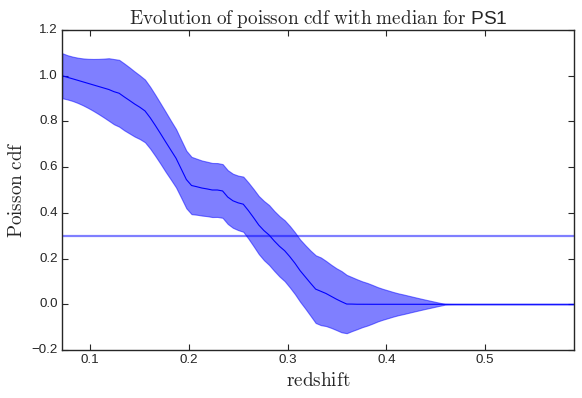

In [20]:
reload(baserate)

baserate.pshow_r(su.value, dataz, 0.2, 100, True)

fig=plt.gcf()
#fig.savefig('/home/nora/Pictures/zmax_' + str(su.value) + '.pdf', bbox_inches='tight')

In [13]:
snls_med = baserate.pshow_r('SNLS', dataz, 0.2, 100, False)
sdss_med = baserate.pshow_r('SDSS', dataz, 0.2, 100, False)
ps1_med = baserate.pshow_r('PS1', dataz, 0.2, 100, False)

z_lin_snlsa = np.linspace(0.1,1.2,len(snls_med))
z_lin_sdssa = np.linspace(0.05,0.35,len(sdss_med))
z_lin_ps1a = np.linspace(0.05,0.5,len(ps1_med))

snls_med_smooth = interp1d(z_lin_snlsa, snls_med, kind='cubic')
sdss_med_smooth = interp1d(z_lin_sdssa, sdss_med, kind='cubic')
ps1_med_smooth = interp1d(z_lin_ps1a, ps1_med, kind='cubic')

<Figure size 800x400 with 0 Axes>

<Figure size 800x400 with 0 Axes>

<Figure size 800x400 with 0 Axes>

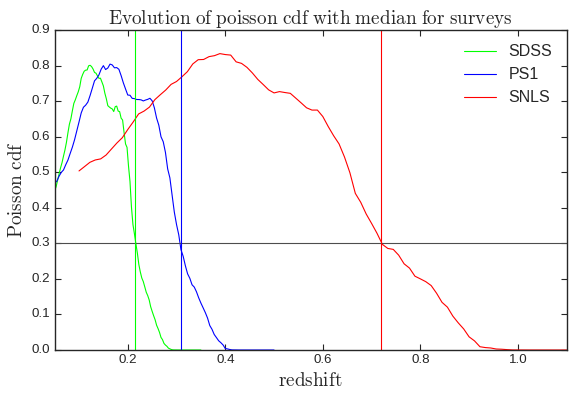

In [25]:
fig = plt.figure(figsize=[8, 5])
ax = fig.add_axes([0.1, 0.12, 0.8, 0.8])

ax.plot(z_lin_sdssa,
        sdss_med_smooth(z_lin_sdssa),
        '-', color=colors['SDSS'],
        label = 'SDSS')
ax.plot(z_lin_ps1a,
        ps1_med_smooth(z_lin_ps1a),
        '-', color=colors['PS1'],
        label = 'PS1')
ax.plot(z_lin_snlsa,
        snls_med_smooth(z_lin_snlsa),
        '-', color=colors['SNLS'],
        label = 'SNLS')

ax.hline(0.3,
         color="0.3", lw=1.0)

ax.vline(0.72,
         color=colors['SNLS'], lw=1.0)

ax.vline(0.215,
         color=colors['SDSS'], lw=1.0)

ax.vline(0.31,
         color=colors['PS1'], lw=1.0)

ax.tick_params(direction='in',
               length=5, width=1,
               labelsize=12,
               top=True, right=True)
                                                                        
ax.set_xlim(np.min(z_lin_sdssa), 1.1)
                                                                        
ax.set_xlabel(r'$\mathrm{redshift}$', fontsize='x-large')
ax.set_ylabel(r'$\mathrm{Poisson\,\,cdf}$', fontsize='x-large')

plt.legend(ncol=1, loc='upper right')
                                                                        
plt.title(r'$\mathrm{Evolution\,\,of\,\,poisson\,\,cdf\,\,with\,\,}$' +
          r'$\mathrm{median\,\,for\,\,surveys}$',
          fontsize='x-large')

fig=plt.gcf()
fig.savefig('/home/nora/Documents/Thèse/Images/zmax_determination.pdf')

In [49]:
print(snls_med_smooth(0.7) - 0.30)
print(sdss_med_smooth(0.22) - 0.30)
print(ps1_med_smooth(0.33) - 0.30)

0.09439378384118757
0.05296288164532137
-0.08637855053995569


In [10]:
dx = 0.01
snls_med_der = [np.abs((snls_med[i+1] - snls_med[i]))/dx for i in range(len(snls_med)-1)]
sdss_med_der = [np.abs((sdss_med[i+1] - sdss_med[i]))/dx for i in range(len(sdss_med)-1)]
ps1_med_der = [np.abs((ps1_med[i+1] - ps1_med[i]))/dx for i in range(len(ps1_med)-1)]

(0, 6)

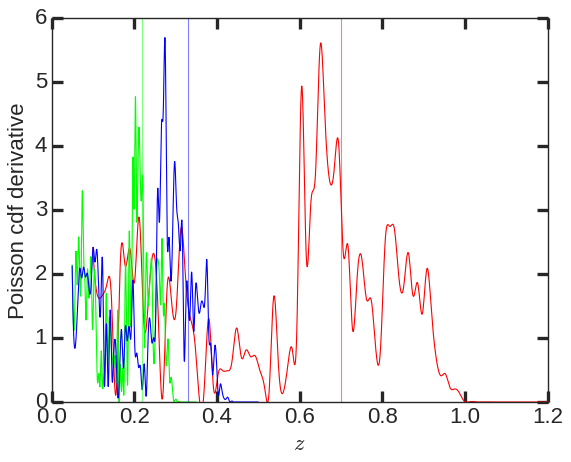

In [20]:
z_lin_snls = np.linspace(0.1,1.2,len(snls_med_der))
z_lin_sdss = np.linspace(0.05,0.35,len(sdss_med_der))
z_lin_ps1 = np.linspace(0.05,0.5,len(ps1_med_der))

snls_smooth = interp1d(z_lin_snls, snls_med_der, kind='cubic')
sdss_smooth = interp1d(z_lin_sdss, sdss_med_der, kind='cubic')
ps1_smooth = interp1d(z_lin_ps1, ps1_med_der, kind='cubic')

z_lin_snls_smooth = np.linspace(0.1, 1.2, 1000)
z_lin_sdss_smooth = np.linspace(0.05, 0.35, 1000)
z_lin_ps1_smooth= np.linspace(0.05, 0.5, 1000)

plt.plot(z_lin_snls_smooth, snls_smooth(z_lin_snls_smooth), '-', color=colors['SNLS'])
plt.plot(z_lin_sdss_smooth, sdss_smooth(z_lin_sdss_smooth), '-', color=colors['SDSS'])
plt.plot(z_lin_ps1_smooth, ps1_smooth(z_lin_ps1_smooth), '-', color=colors['PS1'])

plt.plot([zmax['SNLS'], zmax['SNLS']], [0,6], color=colors['SNLS'], alpha=.5)
plt.plot([zmax['SDSS'], zmax['SDSS']], [0,6], color=colors['SDSS'], alpha=.5)
plt.plot([zmax['PS1'], zmax['PS1']], [0,6], color=colors['PS1'], alpha=.5)

ax = plt.gca()
ax.tick_params(axis='both',
               direction='in',
               length=10, width=3,
               labelsize=20,
               which='both',
               top=True, right=True)
plt.xlabel('$z$', fontsize=20)
plt.ylabel('Poisson cdf derivative', fontsize=20)

plt.ylim(0,6)

#plt.title('Evolution of poisson cdf with median for ' +
#          str(survey), fontsize=20)


## Base model

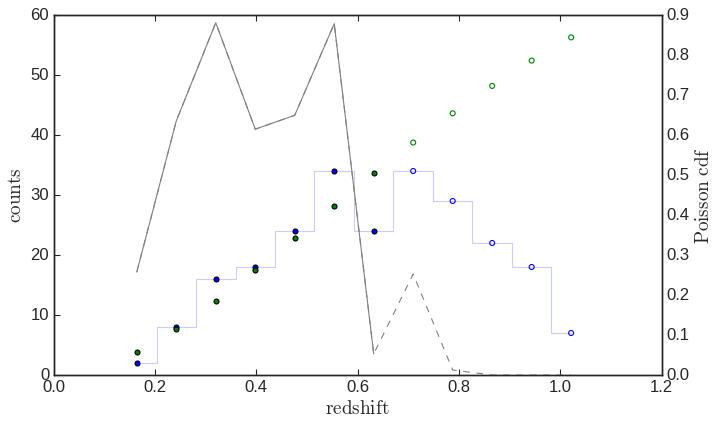

In [69]:
reload(baserate)

base = baserate.VolumeNoModel()
ratefitter = baserate.RateFitter()
ratefitter.set_data(countsz, binsz)
ratefitter.set_model(base)
ratefitter.set_fitted_flag(ratefitter._central_redshiftranges < 0.7)
ratefitter.fit(a_guess = 0.2)
_ = ratefitter.show(add_proba = True)

fig=plt.gcf()
fig.savefig('/home/nora/Documents/Thèse/Images/zmax_method_7.pdf', bbox_inches='tight')

## Volume Model

In [8]:
redshiftsA = ratefitter._properties['redshift_ranges'][1]
redshiftsB = ratefitter._properties['redshift_ranges'][0]

flag_upA = redshiftsA > 0.7
missedA = np.zeros(len(redshiftsA))

missedA[flag_upA] = 0.2*cosmo.comoving_volume(redshiftsA[flag_upA]).value/1e8

flag_upB = redshiftsB > 0.7
missedB = np.zeros(len(redshiftsB))

missedB[flag_upB] = 0.2*cosmo.comoving_volume(redshiftsB[flag_upB]).value/1e8

print(missedA-missedB)

[  0.           0.           0.           0.           0.
   0.           0.         168.8476028   44.36890343  49.010051
  53.30241094  57.23491884]


/home/nora/installs/anaconda3/lib/python3.7/site-packages/scipy/stats/_discrete_distns.py:495: RuntimeWarning: invalid value encountered in greater_equal
  return mu >= 0


{'b': 0.3, 'zmax': 0.7}

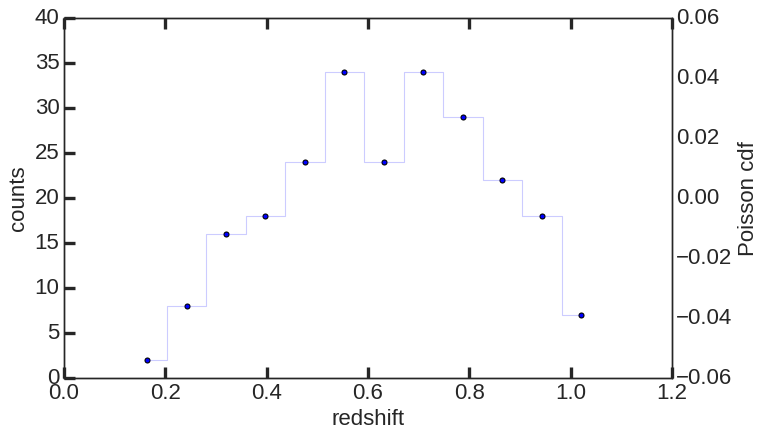

In [9]:
reload(baserate)

volume = baserate.VolumeVolumeModel()
ratefitter = baserate.RateFitter()
ratefitter.set_data(countsz, binsz)
ratefitter.set_model(volume)
ratefitter.fit(a_guess = 0.2, b_guess = 0.3, zmax_guess = 0.7,
               b_fixed = True, zmax_fixed = True)
_ = ratefitter.show(add_proba = True)
volume.parammissed

## Expo Model

/home/nora/installs/anaconda3/lib/python3.7/site-packages/scipy/stats/_discrete_distns.py:495: RuntimeWarning: invalid value encountered in greater_equal
  return mu >= 0
/home/nora/installs/anaconda3/lib/python3.7/site-packages/modefit-0.2.4-py3.7.egg/modefit/baseobjects.py:1269: UserWarning: migrad is not valid
  warnings.warn("migrad is not valid")
/home/nora/installs/anaconda3/lib/python3.7/site-packages/modefit-0.2.4-py3.7.egg/modefit/baseobjects.py:1225: UserWarning: Inaccurate covariance Matrix. Only trace defined
  warnings.warn("Inaccurate covariance Matrix. Only trace defined")


{'b': 5316.234720963694, 'zmax': 0.7486620139677895, 'zc': 0.07845836687013252}

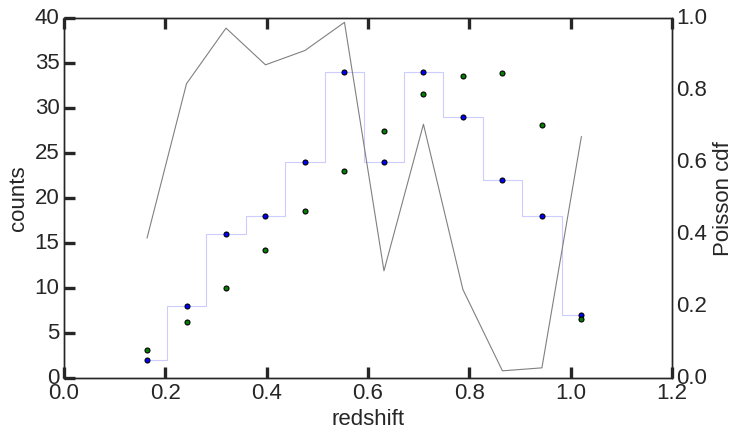

In [133]:
reload(baserate)

expo = baserate.VolumeExpoModel()
ratefitter = baserate.RateFitter()
ratefitter.set_data(countsz, binsz)
ratefitter.set_model(expo)
#ratefitter.set_fitted_flag(ratefitter._central_redshiftranges < 0.7)
ratefitter.fit(a_guess = 0.2, b_guess = 1, zmax_guess = 0.7, zc_guess = 1e-1,\
               #b_fixed = True, zmax_fixed = True, zc_fixed = True\
              )
_ = ratefitter.show(add_proba = True)
expo.parammissed

## Const model

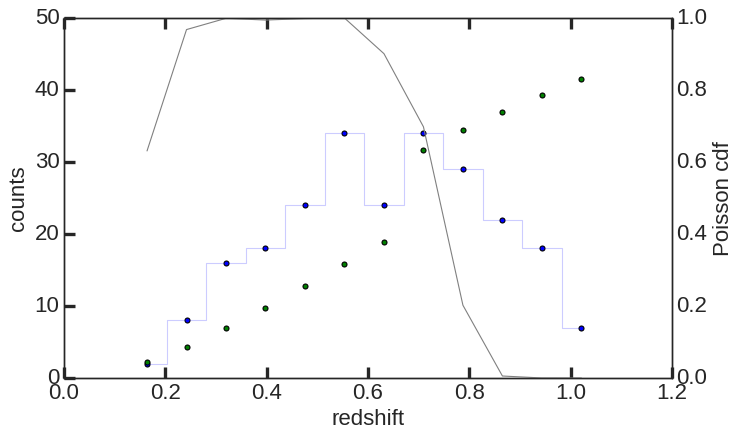

In [137]:
reload(baserate)

const = baserate.VolumeConstModel()
ratefitter = baserate.RateFitter()
ratefitter.set_data(countsz, binsz)
ratefitter.set_model(const)
#ratefitter.set_fitted_flag(ratefitter._central_redshiftranges<0.7)
ratefitter.fit(a_guess = 0.2, zmax_guess = 0.7,
               zmax_fixed = True)
_ = ratefitter.show(add_proba = True)